In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# plt.rcParams["font.family"] = "Arial"
# from skimage import measure
import pyvista as pv
# pv.set_jupyter_backend('static')
from tqdm import tqdm, trange
from scipy import interpolate, ndimage, fft
from scipy.io import savemat, loadmat
from time import time
from PIL import Image
from scipy.interpolate import splrep, splev
# from numba import jit
from Vortex import *
from Render import *

In [2]:
## dispersion relation
def f_omega_deBroglie(k,D=1):
    k_norm = np.linalg.norm(k)
    return D*k_norm**2

def f_omega_em(k,c=1):
    k_norm = np.linalg.norm(k)
    return c*k_norm

def f_omega_dos(k,mu=1,sigma=0.01):
    omega_list = np.arange(1000)/1000*2
    p_omega = np.exp(-(omega_list-mu)**2/2/sigma**2)
    bins = np.arange(1001)/1000
    return draw_from_hist(p_omega,bins,nsamples=1)[0]

In [3]:
## scattering function
def rearrange(F_q):
    ind_max = int(F_q.shape[0]/2)
    # beam stopper
    F_q[0,0,0] = (np.sum(F_q[0:2,0:2,0:2])-F_q[0,0,0])/7
    # rearrange FFT datapoints
    # rearrange x
    F_q_xpos = F_q[0:ind_max,:,:]
    F_q_xneg = F_q[ind_max:,:,:]
    F_q_x = np.concatenate((F_q_xneg,F_q_xpos),axis=0)
    # rearrange y
    F_q_ypos = F_q_x[:,0:ind_max,:]
    F_q_yneg = F_q_x[:,ind_max:,:]
    F_q_y = np.concatenate((F_q_yneg,F_q_ypos),axis=1)
    # rearrange z
    F_q_zpos = F_q_y[:,:,0:ind_max]
    F_q_zneg = F_q_y[:,:,ind_max:]
    F_q_z = np.concatenate((F_q_zneg,F_q_zpos),axis=2)
    return F_q_z

def rho_fft(rho_t, alpha=0):
    F_q_list = []
    for i_t, t in tqdm(enumerate(t_list)):
        rho = rho_t[i_t]
        
        N = (rho.shape[0]) ** 3  # Number of grid points after scaling
        
        rho_bi = np.zeros_like(rho)  # Density = 0 or 1
        rho_bi[rho > alpha] = 1  # Clipped to alpha
        
        F_q = np.fft.fftn(rho_bi)  # FFT of the grid density
        # F_q = np.fft.fftshift(F_q)
        F_q = rearrange(F_q)
        F_q_list.append(F_q)
    return F_q_list
    
def reduce_I_qt(F_q_list, n_grid_scale, t_list):
    f_qt = []
    I_qt = []
    N = n_grid_scale ** 3

    ind_max = int(n_grid_scale/2)
    q_grid = np.arange(n_grid_scale)
    q_grid = q_grid-ind_max
    qq_xyz = np.meshgrid(q_grid,q_grid,q_grid)

    n_qq = int(ind_max)
    qq = np.arange(n_qq)
    dq = qq[1]-qq[0]
    index_qq_xyz = np.floor(np.sqrt(qq_xyz[0]**2+qq_xyz[1]**2+qq_xyz[2]**2)/dq).astype(int).flatten()

    for i_dt in trange(len(t_list)-1):
        f_qti = np.zeros_like(F_q_list[0])
        for i_t0 in range(len(t_list)-i_dt-1):
            f_qti += F_q_list[i_t0]*np.conj(F_q_list[i_t0+i_dt])
        f_qti = f_qti/(len(t_list)-i_dt-1)/N
        
        f_qt.append(f_qti)
        
        I_qti = np.zeros_like(qq).astype(complex)
        n_q = np.zeros_like(qq)
        for i_f, f in enumerate(np.abs(f_qti).flatten()):
            index = index_qq_xyz[i_f]
            if index<n_qq:
                I_qti[index] += f
                n_q[index] += 1
        I_qti = I_qti/n_q
        I_qt.append(I_qti)

    I_qt = np.array(I_qt)
    return qq, I_qt
    

In [4]:
## Meshgrid
n_grid = 64-1
scale = 2.5
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

n_time = 201
t_list = np.linspace(0,1,n_time)*80*np.pi # collect for omega_0*t = 40pi

## 1. Monochromatic

In [5]:
sigma_k = 1e-8
kappa_list = [64]
# sigma_omega_list = [0.05, 0.1, 0.2]
sigma_omega_list = [0.1]

parameters_list = []
rho_list = []

k_bar = scale*2*np.pi

rho_list = []
I_qt_list = []
for kappa in kappa_list:
    for sigma_omega in sigma_omega_list:
        ## Random wave
        alpha = 0

        parameters = [sigma_k,kappa,alpha,sigma_omega]
        parameters_list.append(parameters)
        
        ## Wave vector distribution 
        k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
        # k_mean_x = np.array([0,0,0])*np.pi # lamellar perpendicular to z axis 
        k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
        k_cov  = np.diagflat(k_var)
        
        ## Generate randomwave vector
        phi_r_list, k_sample_rot_list, omega_list = sample_wave_vect(k_mean_z, k_cov, n_wave=64, kappa=kappa, seed=114514, f_omega=lambda x: f_omega_dos(x,sigma=sigma_omega))
            
        rho_t = []
        for t in tqdm(t_list):
            
            # rho = sample_wave_dispersion(r_grid, k_mean_z, k_cov, t=t, f_omega=f_omega_em, n_wave = 50, kappa=kappa, seed=1145141)
            rho = sample_wave_time(r_grid, phi_r_list, k_sample_rot_list, omega_list, t=t)
            rho_t.append(rho) # append this timestep
            
        rho_list.append(rho_t)
        
        ## Space-Time Correlation
        ### FFT each frame
        n_grid_scale = 64

        F_q_list = rho_fft(rho_t)
        qq, I_qt = reduce_I_qt(F_q_list, n_grid_scale, t_list)
        
        I_qt_list.append(I_qt)
        
rho_list = np.array(rho_list)
I_qt_list = np.array(I_qt_list)


filename = "./mat/test/Monochromatic.mat"
mdict = {"qq":qq, "t_list":t_list, "rho_list":rho_list, "I_qt_list":I_qt_list}
savemat(filename,mdict)

  0%|          | 0/201 [00:00<?, ?it/s]

100%|██████████| 201/201 [01:14<00:00,  2.69it/s]
201it [00:01, 168.32it/s]
100%|██████████| 200/200 [00:26<00:00,  7.67it/s]


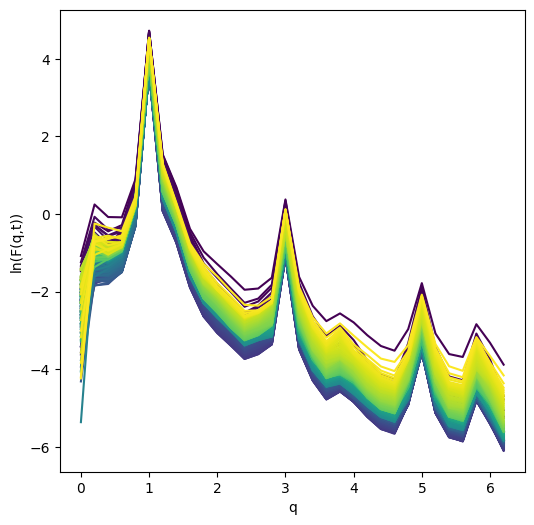

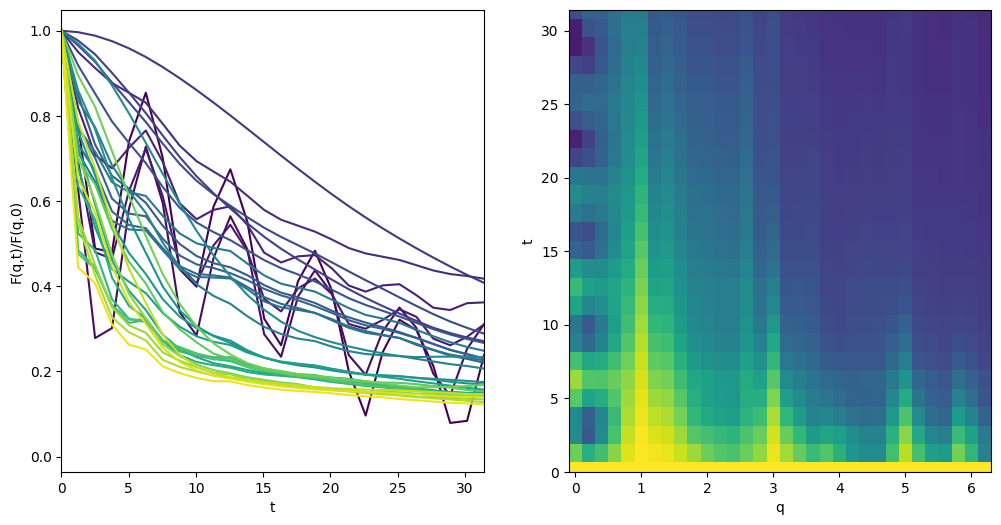

In [6]:
I_qt_real = np.real(I_qt_list[0])
cmap = matplotlib.colormaps["viridis"]
t_max = 10*np.pi

# rescale qq
L=2
qq_r = qq*2*np.pi/L * (L/2)/scale/(2*np.pi)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

for i_t, t in enumerate(t_list[:-1]):
    ax.plot(qq_r,np.log(I_qt_real[i_t,:]),color = cmap(i_t/len(t_list[:-1])))

ax.set_xlabel("q")
ax.set_ylabel("ln(F(q,t))")

t_plot, q_plot = np.meshgrid(qq_r, t_list[:-1])


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)

for i_q, q in enumerate(qq):
    ax.plot(t_list[:-1],I_qt_real[:,i_q]/I_qt_real[0,i_q],color = cmap(i_q/len(qq)))

ax.set_xlim([0,t_max])
ax.set_xlabel("t")
ax.set_ylabel("F(q,t)/F(q,0)")

# fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 2, 2)
ax.pcolormesh(t_plot, q_plot, ((I_qt_real/I_qt_real[0,:])), vmax=1, vmin=0)

ax.set_ylim([0,t_max])
ax.set_xlabel("q")
ax.set_ylabel("t")


plt.show()

## 2. Dispersion relation

In [7]:
# sigma_k_list = [0.05, 0.1, 0.2]
sigma_k_list = [0.1]
kappa_list = [64]
k_bar = scale*2*np.pi
c = 1.0*0.1
D = 1/(2*k_bar)*0.1

parameters_list = []
rho_list = []



In [8]:
rho_list = []
I_qt_list = []
for kappa in kappa_list:
    for sigma_k in sigma_k_list:
        ## Random wave
        alpha = 0

        parameters = [sigma_k,kappa,alpha,sigma_omega]
        parameters_list.append(parameters)
        
        ## Wave vector distribution 
        k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
        # k_mean_x = np.array([0,0,0])*np.pi # lamellar perpendicular to z axis 
        k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
        k_cov  = np.diagflat(k_var)
        
        ## Generate randomwave vector
        phi_r_list, k_sample_rot_list, omega_list = sample_wave_vect(k_mean_z, k_cov, n_wave=64, kappa=kappa, seed=114514, f_omega=lambda x: f_omega_deBroglie(x,D=D))
            
        rho_t = []
        for t in tqdm(t_list):
            
            # rho = sample_wave_dispersion(r_grid, k_mean_z, k_cov, t=t, f_omega=f_omega_em, n_wave = 50, kappa=kappa, seed=1145141)
            rho = sample_wave_time(r_grid, phi_r_list, k_sample_rot_list, omega_list, t=t)
            rho_t.append(rho) # append this timestep
            
        rho_list.append(rho_t)
        
        ## Space-Time Correlation
        ### FFT each frame
        n_grid_scale = 64

        F_q_list = rho_fft(rho_t)
        qq, I_qt = reduce_I_qt(F_q_list, n_grid_scale, t_list)
        
        I_qt_list.append(I_qt)
        
rho_list = np.array(rho_list)
I_qt_list = np.array(I_qt_list)


filename = "./mat/test/deBrogile.mat"
mdict = {"qq":qq, "t_list":t_list, "rho_list":rho_list, "I_qt_list":I_qt_list}
savemat(filename,mdict)

100%|██████████| 201/201 [01:09<00:00,  2.88it/s]
201it [00:02, 91.44it/s]
100%|██████████| 200/200 [00:26<00:00,  7.53it/s]


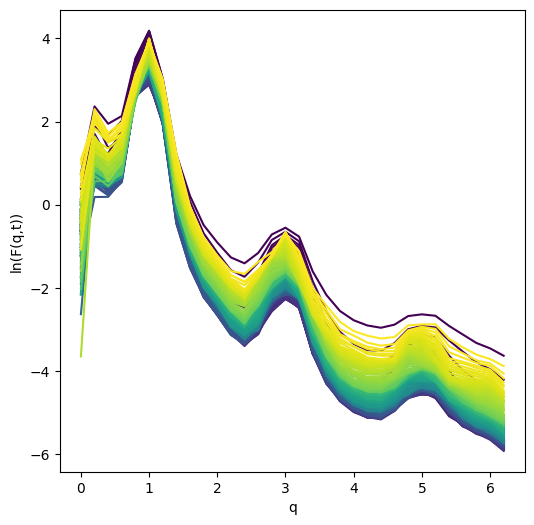

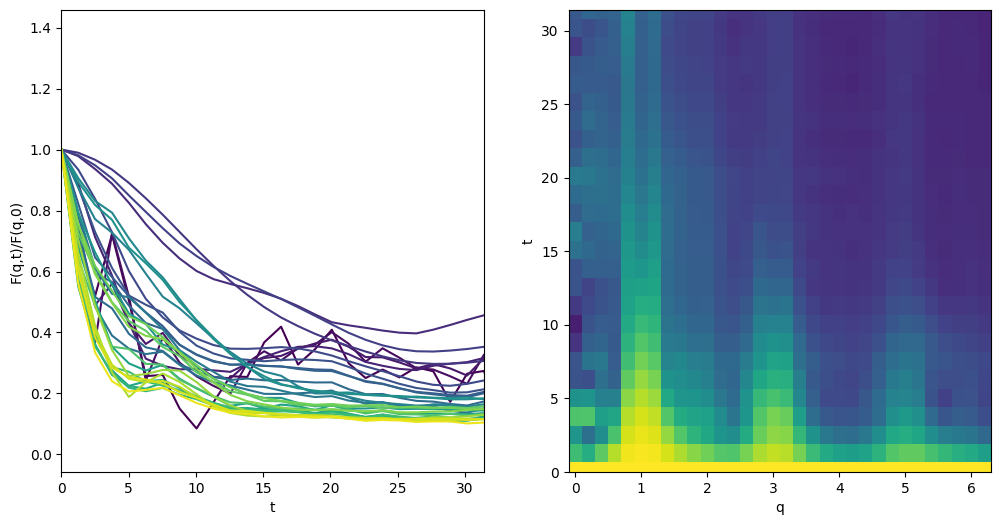

In [9]:
I_qt_real = np.real(I_qt_list[0])
cmap = matplotlib.colormaps["viridis"]
t_max = 10*np.pi

# rescale qq
L=2
qq_r = qq*2*np.pi/L * (L/2)/scale/(2*np.pi)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

for i_t, t in enumerate(t_list[:-1]):
    ax.plot(qq_r,np.log(I_qt_real[i_t,:]),color = cmap(i_t/len(t_list[:-1])))

ax.set_xlabel("q")
ax.set_ylabel("ln(F(q,t))")

t_plot, q_plot = np.meshgrid(qq_r, t_list[:-1])


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)

for i_q, q in enumerate(qq):
    ax.plot(t_list[:-1],I_qt_real[:,i_q]/I_qt_real[0,i_q],color = cmap(i_q/len(qq)))

ax.set_xlim([0,t_max])
ax.set_xlabel("t")
ax.set_ylabel("F(q,t)/F(q,0)")

# fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 2, 2)
ax.pcolormesh(t_plot, q_plot, ((I_qt_real/I_qt_real[0,:])), vmax=1, vmin=0)

ax.set_ylim([0,t_max])
ax.set_xlabel("q")
ax.set_ylabel("t")


plt.show()

In [10]:
rho_list = []
I_qt_list = []
for kappa in kappa_list:
    for sigma_k in sigma_k_list:
        ## Random wave
        alpha = 0

        parameters = [sigma_k,kappa,alpha,sigma_omega]
        parameters_list.append(parameters)
        
        ## Wave vector distribution 
        k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
        # k_mean_x = np.array([0,0,0])*np.pi # lamellar perpendicular to z axis 
        k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
        k_cov  = np.diagflat(k_var)
        
        ## Generate randomwave vector
        phi_r_list, k_sample_rot_list, omega_list = sample_wave_vect(k_mean_z, k_cov, n_wave=64, kappa=kappa, seed=114514, f_omega=lambda x: f_omega_em(x,c=c))
            
        rho_t = []
        for t in tqdm(t_list):
            
            # rho = sample_wave_dispersion(r_grid, k_mean_z, k_cov, t=t, f_omega=f_omega_em, n_wave = 50, kappa=kappa, seed=1145141)
            rho = sample_wave_time(r_grid, phi_r_list, k_sample_rot_list, omega_list, t=t)
            rho_t.append(rho) # append this timestep
            
        rho_list.append(rho_t)
        
        ## Space-Time Correlation
        ### FFT each frame
        n_grid_scale = 64

        F_q_list = rho_fft(rho_t)
        qq, I_qt = reduce_I_qt(F_q_list, n_grid_scale, t_list)
        
        I_qt_list.append(I_qt)
        
rho_list = np.array(rho_list)
I_qt_list = np.array(I_qt_list)


filename = "./mat/test/em.mat"
mdict = {"qq":qq, "t_list":t_list, "rho_list":rho_list, "I_qt_list":I_qt_list}
savemat(filename,mdict)

100%|██████████| 201/201 [01:12<00:00,  2.76it/s]
201it [00:02, 90.24it/s]
100%|██████████| 200/200 [00:26<00:00,  7.56it/s]


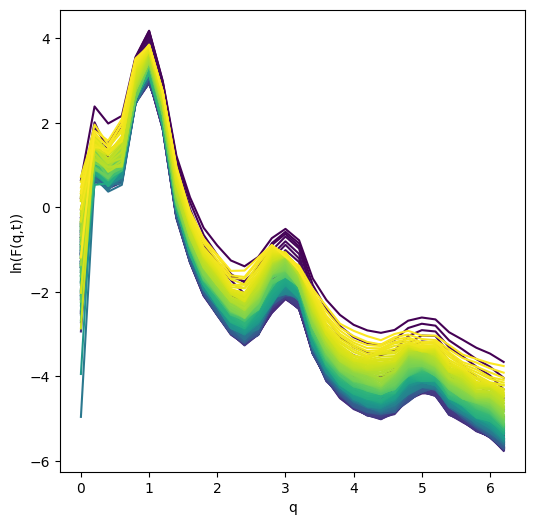

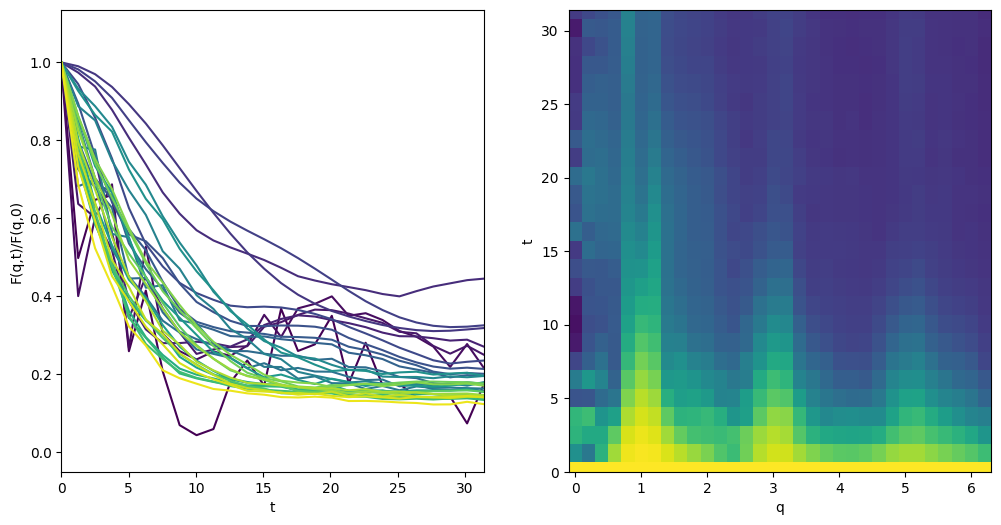

In [11]:
I_qt_real = np.real(I_qt_list[0])
cmap = matplotlib.colormaps["viridis"]
t_max = 10*np.pi

# rescale qq
L=2
qq_r = qq*2*np.pi/L * (L/2)/scale/(2*np.pi)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

for i_t, t in enumerate(t_list[:-1]):
    ax.plot(qq_r,np.log(I_qt_real[i_t,:]),color = cmap(i_t/len(t_list[:-1])))

ax.set_xlabel("q")
ax.set_ylabel("ln(F(q,t))")

t_plot, q_plot = np.meshgrid(qq_r, t_list[:-1])


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)

for i_q, q in enumerate(qq):
    ax.plot(t_list[:-1],I_qt_real[:,i_q]/I_qt_real[0,i_q],color = cmap(i_q/len(qq)))

ax.set_xlim([0,t_max])
ax.set_xlabel("t")
ax.set_ylabel("F(q,t)/F(q,0)")

# fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 2, 2)
ax.pcolormesh(t_plot, q_plot, ((I_qt_real/I_qt_real[0,:])), vmax=1, vmin=0)

ax.set_ylim([0,t_max])
ax.set_xlabel("q")
ax.set_ylabel("t")


plt.show()

## 3. Plot saved results

In [28]:
def unpack_data(data):
    qq = data["qq"][0]
    t_list = data["t_list"][0]
    rho_list = data["rho_list"]
    I_qt_list = data["I_qt_list"]
    return qq, t_list, rho_list, I_qt_list

In [69]:
def figure_q(ax, qq, t_list, I_qt_real, cmap = matplotlib.colormaps["viridis"]):
    I_qt_real = np.real(I_qt_list[0])
    # rescale qq
    L=2
    qq_r = qq*2*np.pi/L * (L/2)/scale/(2*np.pi)

    for i_t, t in enumerate(t_list[:-1]):
        ax.plot(qq_r,np.log(I_qt_real[i_t,:]),color = cmap(i_t/len(t_list[:-1])))

    ax.set_xlabel("q")
    ax.set_ylabel("ln(F(q,t))")


def figure_t(ax, qq, t_list, I_qt_list, t_max=10*np.pi, cmap = matplotlib.colormaps["viridis"]):
    I_qt_real = np.real(I_qt_list[0])

    for i_q, q in enumerate(qq):
        ax.plot(t_list[:-1],I_qt_real[:,i_q]/I_qt_real[0,i_q],color = cmap(i_q/len(qq)))

    ax.set_xlim([0,t_max])
    ax.set_ylim([0,1])
    ax.set_xlabel("t")
    ax.set_ylabel("F(q,t)/F(q,0)")


def figure_qt(ax, qq, t_list, I_qt_list, t_max=10*np.pi, cmap = matplotlib.colormaps["viridis"]):
    I_qt_real = np.real(I_qt_list[0])
    # rescale qq
    L=2
    qq_r = qq*2*np.pi/L * (L/2)/scale/(2*np.pi)
    
    t_plot, q_plot = np.meshgrid(qq_r, t_list[:-1])
    
    ax.pcolormesh(t_plot, q_plot, ((I_qt_real/I_qt_real[0,:])), vmax=1, vmin=0)

    ax.set_xlabel("q")
    ax.set_ylabel("t")
    
    # ax.set_xscale("log")
    # ax.set_yscale("log")
    
    ax.set_ylim([t_list[0],t_max])

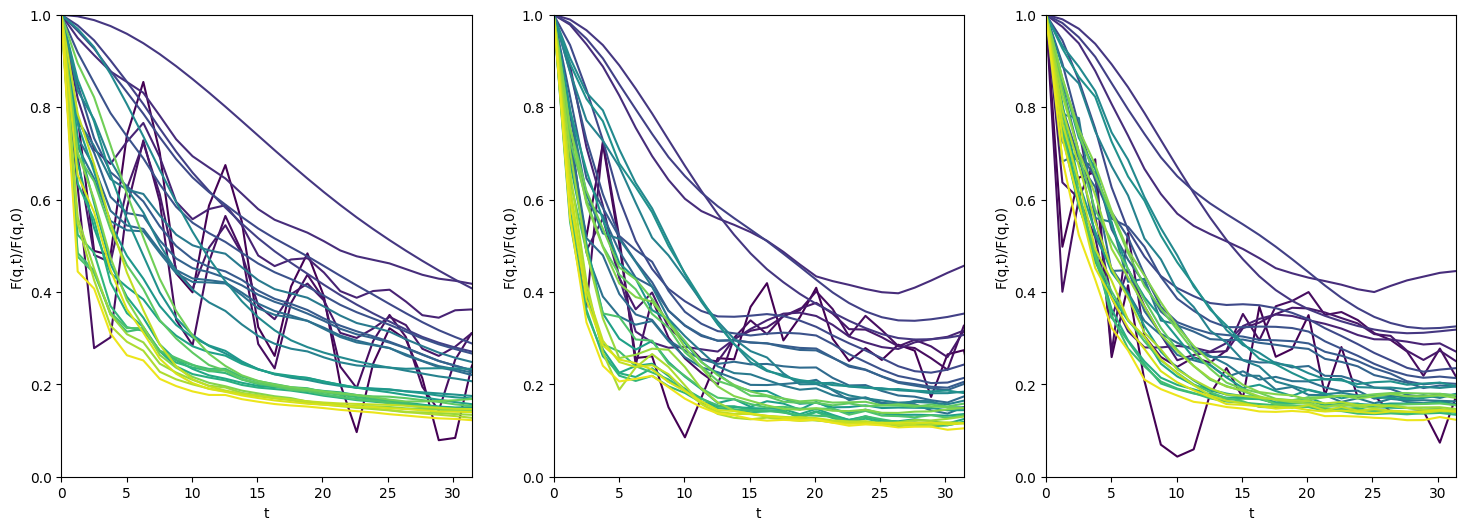

In [70]:
fig = plt.figure(figsize=(18,6))

filename = "./mat/test/Monochromatic.mat"
data = loadmat(filename)
qq, t_list, rho_list, I_qt_list = unpack_data(data)
ax = fig.add_subplot(1,3,1)
figure_t(ax, qq, t_list, I_qt_list, t_max=10*np.pi, cmap = matplotlib.colormaps["viridis"])

filename = "./mat/test/deBrogile.mat"
data = loadmat(filename)
qq, t_list, rho_list, I_qt_list = unpack_data(data)
ax = fig.add_subplot(1,3,2)
figure_t(ax, qq, t_list, I_qt_list, t_max=10*np.pi, cmap = matplotlib.colormaps["viridis"])

filename = "./mat/test/em.mat"
data = loadmat(filename)
qq, t_list, rho_list, I_qt_list = unpack_data(data)
ax = fig.add_subplot(1,3,3)
figure_t(ax, qq, t_list, I_qt_list, t_max=10*np.pi, cmap = matplotlib.colormaps["viridis"])

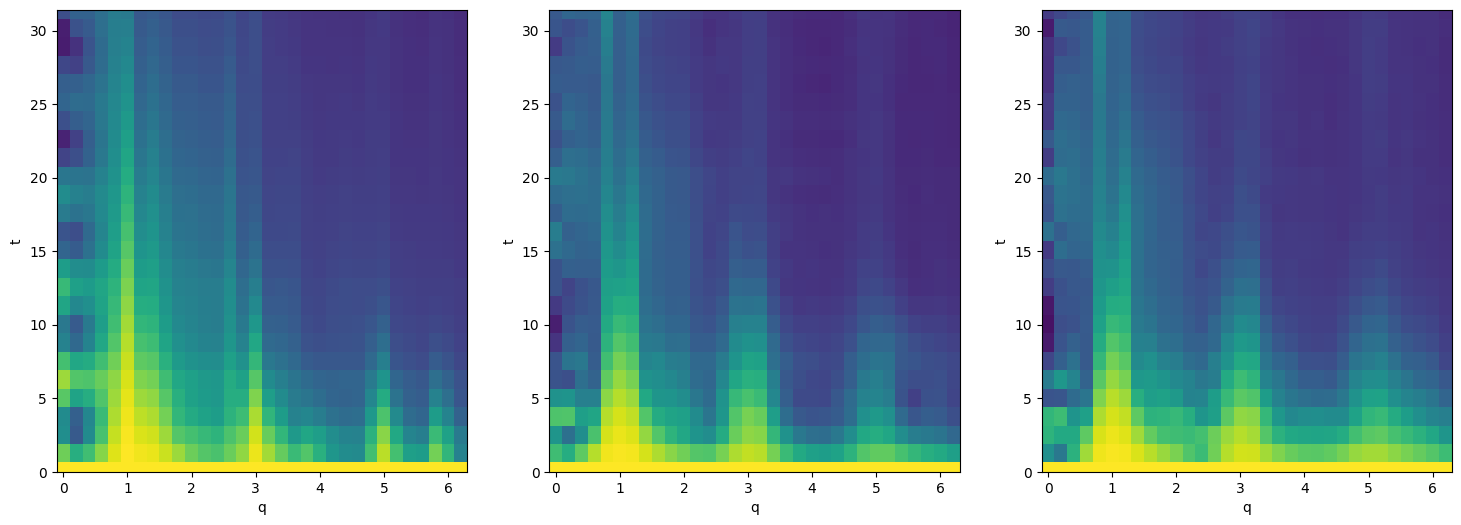

In [71]:
fig = plt.figure(figsize=(18,6))

filename = "./mat/test/Monochromatic.mat"
data = loadmat(filename)
qq, t_list, rho_list, I_qt_list = unpack_data(data)
ax = fig.add_subplot(1,3,1)
figure_qt(ax, qq, t_list, I_qt_list, t_max=10*np.pi, cmap = matplotlib.colormaps["viridis"])

filename = "./mat/test/deBrogile.mat"
data = loadmat(filename)
qq, t_list, rho_list, I_qt_list = unpack_data(data)
ax = fig.add_subplot(1,3,2)
figure_qt(ax, qq, t_list, I_qt_list, t_max=10*np.pi, cmap = matplotlib.colormaps["viridis"])

filename = "./mat/test/em.mat"
data = loadmat(filename)
qq, t_list, rho_list, I_qt_list = unpack_data(data)
ax = fig.add_subplot(1,3,3)
figure_qt(ax, qq, t_list, I_qt_list, t_max=10*np.pi, cmap = matplotlib.colormaps["viridis"])